<a href="https://colab.research.google.com/github/Yaivi/Proyecto-FSI/blob/main/TrabajoFSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#COLOCAR AQUI LOS HIPERPARÁMETROS POR LOS QUE SE REGIRÁ LA PRÁCTICA AL EJECUTARSE
DATASET_PERCENT = .5

TRAIN_PERCENT = .7
VAL_PERCENT = .2
TEST_PERCENT = .1

IMAGE_SIZE = 128

RANDOM_STATE = None

BATCH_SIZE = 20
LEARNING_RATE = 0.001
MOMENTUM = 0.9
NUM_EPOCH = 10
EARLY_PATIENCE = 10
SCHEDULER_PATIENCE = 6




In [17]:
import kagglehub
import torch
import random
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset



transform = transforms.Compose([
    transforms.ToTensor(),  # Convertimos imágenes a Tensores
    transforms.Normalize((0.5,), (0.5,)),  # Normalizamos con media 0.5 y desviación estándar 0.5

    # Ajustar el tamaño de las imágenes para que todas tengan el mismo tamaño
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
])


# Cargar el dataset que hemos elegido
#Especificar la ruta que debe seguir para entrar en el directorio con las carpetas que serán los labels
path = kagglehub.dataset_download("prasunroy/natural-images")
train_path = os.path.join(path, "natural_images")
print("Path to dataset files:", train_path )


# Cargamos el dataset en test, train y validation
dataset = datasets.ImageFolder(root=train_path, transform=transform)
print(dataset.classes)
num_classes = len(dataset.classes)


#fraccion del dataset para no sobrecargarlo
subset_size  = int(len(dataset) * DATASET_PERCENT)
subset_indices = random.sample(range(len(dataset)), subset_size)  # Seleccionamos índices aleatorios
subset = Subset(dataset, subset_indices)  # Creamos el subconjunto
print(len(dataset))

# Generar índices para entrenamiento, validación y prueba
indices = list(range(len(subset)))
random.shuffle(indices)  # Barajamos los índices

# Calculamos los tamaños
train_size = int(TRAIN_PERCENT * len(indices))
val_size = int(VAL_PERCENT * len(indices))
test_size = int(TEST_PERCENT * len(indices))
print(len(indices), train_size+val_size+test_size)

# Dividimos los índices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Creamos los subsets
train_subset = Subset(subset, train_indices)
val_subset = Subset(subset, val_indices)
test_subset = Subset(subset, test_indices)

# DataLoader para cargar los datos
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
validation_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)


print("Máximo valor de la imagen:", train_subset[0][0].squeeze().max())
print("Mínimo valor de la imagen:",train_subset[0][0].squeeze().min())


Path to dataset files: /root/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1/natural_images
['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
6899
3449 3447
Máximo valor de la imagen: tensor(1.)
Mínimo valor de la imagen: tensor(-1.)


In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Imágenes de 128x128 neuronas [64, 784]entradas a 512
        # 512 a 256 neuronas
        # 256 a 10 neuronas (10 clases de MNIST)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling con un kernel de 2x2
        # Capa convolucional 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Capas completamente conectadas
        self.fc1 = nn.Linear(32 * 32 * 64, 30)  # Ajustamos el tamaño de entrada
        self.fc2 = nn.Linear(30, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Aplicamos ReLU y max pooling después de conv1
        x = self.pool(F.relu(self.conv2(x)))  # Aplicamos ReLU y max pooling después de conv2
        x = x.view(-1, 32 * 32 * 64)  # Aplanamos el tensor
        x = F.relu(self.fc1(x))  # Pasamos por la primera capa completamente conectada
        x = self.fc2(x)  # Pasamos por la segunda capa completamente conectada
        return x

model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)

for epoch in range(NUM_EPOCH):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Limpiamos los gradientes
        outputs = model(images)  # Pasamos las imágenes por la red
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizamos los pesos

        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

Epoch 1, Loss: 1.47625637838715
Epoch 2, Loss: 0.6037599789468866
Epoch 3, Loss: 0.30632263343585164
Epoch 4, Loss: 0.19634139871126727
Epoch 5, Loss: 0.11891340082021136
Epoch 6, Loss: 0.091818602265496
Epoch 7, Loss: 0.04769381008257991
Epoch 8, Loss: 0.02776782503841739


In [8]:
correct = 0
total = 0
with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')

Accuracy of the model on the 10000 test images: 44.67353951890034%


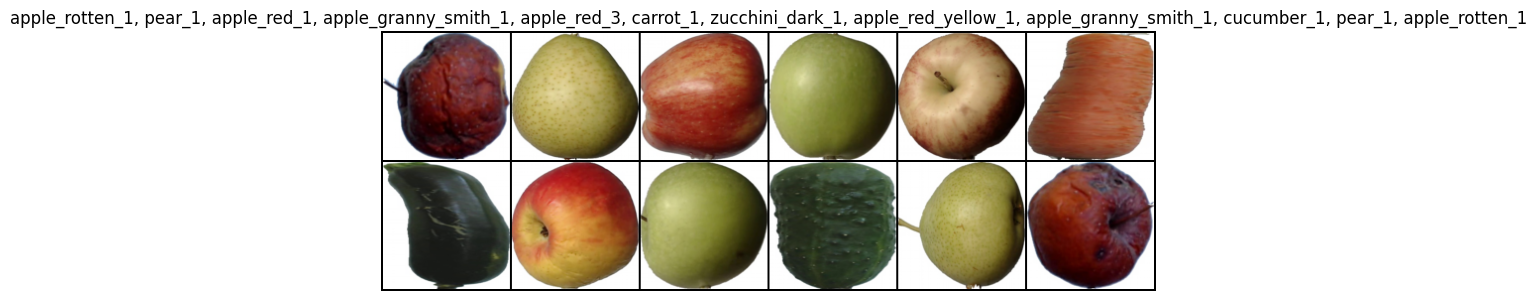

In [ ]:

import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Función para visualizar imágenes del DataLoader
def visualize_dataset(dataloader, class_names, num_images=12):
    """
    Muestra un conjunto de imágenes con sus etiquetas.

    Args:
        dataloader: DataLoader con el dataset.
        class_names: Lista de nombres de las clases.
        num_images: Número de imágenes a mostrar.
    """
    # Obtener un batch de imágenes
    images, labels = next(iter(dataloader))

    # Seleccionar solo las primeras `num_images` imágenes
    images = images[:num_images]
    labels = labels[:num_images]

    # Desnormalizar las imágenes (si fueron normalizadas)
    images = images * 0.5 + 0.5  # Deshacer Normalización (-1 a 1 => 0 a 1)

    # Crear un grid de imágenes
    grid_img = make_grid(images, nrow=6, padding=2)
    np_grid = grid_img.numpy().transpose((1, 2, 0))  # Convertir a formato de Matplotlib

    # Mostrar las imágenes
    plt.figure(figsize=(10, 5))
    plt.imshow(np_grid)
    plt.axis('off')

    # Mostrar etiquetas
    labels_text = [class_names[label] for label in labels]
    plt.title(", ".join(labels_text), fontsize=12)
    plt.show()

class_names = dataset.classes  # Cambia esto por las clases reales
visualize_dataset(test_loader, class_names)

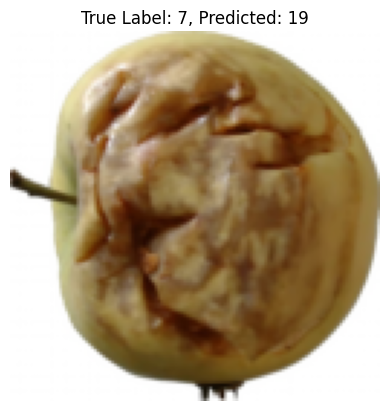

True Label: 7
Predicted Label: 19


In [ ]:
data_iter = iter(train_loader)  # Convertir el DataLoader en un iterador
images, labels = next(data_iter)

# Elegir una imagen aleatoria
random_index = random.randint(0, len(images) - 1)
image = images[random_index]  # Tensor con forma (C, H, W)
label = labels[random_index]

# Desnormalizar la imagen
image = image * 0.5 + 0.5  # Revertir normalización: image = image * std + mean

# Verificar si la imagen tiene múltiples canales (C > 1)
if image.shape[0] == 3:  # Caso RGB con forma (3, H, W)
    image_np = image.permute(1, 2, 0).numpy()  # Cambiar a (H, W, C) para matplotlib
elif image.shape[0] == 1:  # Caso escala de grises con forma (1, H, W)
    image_np = image.squeeze(0).numpy()  # Reducir a (H, W)
else:
    raise ValueError(f"Forma inesperada de la imagen: {image.shape}")

# Realizar la predicción
model.eval()  # Establecer el modelo en modo evaluación
with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
    output = model(image.unsqueeze(0))  # Agregar la dimensión de batch
    _, predicted = torch.max(output.data, 1)  # Obtener la clase predicha

# Mostrar la imagen y la predicción
plt.imshow(image_np, cmap='gray' if image_np.ndim == 2 else None)  # Usar cmap si es escala de grises
plt.title(f'True Label: {label.item()}, Predicted: {predicted.item()}')
plt.axis('off')  # Ocultar los ejes
plt.show()

# Imprimir los valores
print(f'True Label: {label.item()}')
print(f'Predicted Label: {predicted.item()}')

In [ ]:
import matplotlib.pyplot as plt

#Para la gráficas
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

NameError: name 'h' is not defined